In [182]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import norm
from sklearn import preprocessing
from scipy.stats import pearsonr
import math

In [211]:
# Load All-time count of  articles (since 2017) by search terms "NYSE" and "New York Stock Exchange"
stock_news_URL = "https://api.gdeltproject.org/api/v2/doc/doc?format=json&timespan=FULL&query=(NYSE%20OR%20%22New%20York%20Stock%20Exchange%22)&mode=timelinevolraw&timezoom=yes"
with urllib.request.urlopen(stock_news_URL) as url:
    data = json.loads(url.read().decode())
    news_count_df = pd.DataFrame(data["timeline"][0]["data"])
news_count_df = news_count_df.drop([0,1,2,3])
news_count_df["date"] = pd.to_datetime(news_count_df["date"])
news_count_df.set_index('date', drop=True, inplace=True)
news_count_df.set_index(news_count_df.index.tz_localize(None), inplace=True)
news_count_df.rename(columns={'value': 'newsCount'}, inplace=True)
news_count_df

,newsCount,norm
date,,
2017-01-05,4168,830028
2017-01-06,3364,766969
2017-01-07,1848,520691
2017-01-08,1409,488784
2017-01-09,3179,813487
...,...,...
2020-03-20,2253,518601
2020-03-21,910,329009
2020-03-22,350,302307


In [212]:
# News volume intensity
stock_news_URL2 = "https://api.gdeltproject.org/api/v2/doc/doc?query=(NYSE%20or%20%22New%20York%20Stock%20Exchange%22)&mode=timelinevolinfo&TIMELINESMOOTH=5&TIMESPAN=FULL&FORMAT=json"
with urllib.request.urlopen(stock_news_URL2) as url:
    data = json.loads(url.read().decode())
    news_int_df = pd.DataFrame(data["timeline"][0]["data"])

news_int_df = news_int_df.drop(columns=['toparts'])
news_int_df["date"] = pd.to_datetime(news_int_df["date"])
news_int_df.set_index('date', drop=True, inplace=True)
news_int_df.set_index(news_int_df.index.tz_localize(None), inplace=True)
news_int_df.rename(columns={'value': 'newsInt'}, inplace=True)
news_int_df

,newsInt
date,
2017-01-05,0.3827
2017-01-06,0.4144
2017-01-07,0.4393
2017-01-08,0.4165
2017-01-09,0.3950
...,...
2020-03-20,0.4391
2020-03-21,0.4136
2020-03-22,0.3661


In [213]:
# Load stock data from https://finance.yahoo.com/quote/%5ENYA/history?period1=1486857600&period2=1584576000&interval=1d&filter=history&frequency=1d 
stock_df = pd.read_csv("^NYA.csv")
stock_df = stock_df.drop([0,1,2])
stock_df["Date"] = pd.to_datetime(stock_df["Date"], format="%Y-%m-%d")
stock_df.set_index('Date', drop=True, inplace=True)
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-16,11519.320313,11525.209961,11467.370117,11504.190430,11504.190430,3672370000
2017-02-17,11468.009766,11510.919922,11455.660156,11510.910156,11510.910156,3513060000
2017-02-21,11517.940430,11582.639648,11517.940430,11578.250000,11578.250000,3579780000
2017-02-22,11544.169922,11567.950195,11530.849609,11550.179688,11550.179688,3468670000
2017-02-23,11586.959961,11590.349609,11525.410156,11556.150391,11556.150391,4015260000
...,...,...,...,...,...,...
2020-03-12,10466.700195,10646.919922,10054.469727,10060.759766,10060.759766,8829380000
2020-03-13,10445.440430,10851.750000,10060.349609,10851.740234,10851.740234,8258670000
2020-03-16,10851.980469,10851.980469,9559.230469,9567.530273,9567.530273,7781540000


In [214]:
# reindex to fill missing dates and interpolate the corresponding missing values
full_idx = pd.date_range(start=stock_df.index.min(), end=stock_df.index.max(), freq='1D')
stock_df = stock_df.reindex(full_idx)
full_idx = pd.date_range(start=news_int_df.index.min(), end=news_int_df.index.max(), freq='1D')
news_int_df = news_int_df.reindex(full_idx)
full_idx = pd.date_range(start=news_count_df.index.min(), end=news_count_df.index.max(), freq='1D')
news_count_df = news_count_df.reindex(full_idx)

stock_df = stock_df.interpolate()
news_int_df = news_int_df.interpolate()
news_count_df = news_count_df.interpolate()
news_int_df.head(5)#, news_count_df.head(5)

,newsInt
2017-01-05,0.3827
2017-01-06,0.4144
2017-01-07,0.4393
2017-01-08,0.4165
2017-01-09,0.3950


In [215]:
# combine the datasets
df = stock_df.join(news_count_df, how='inner')
df = df.join(news_int_df, how='inner')
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,newsCount,norm,newsInt
2017-02-16,11519.320313,11525.209961,11467.370117,11504.190430,11504.190430,3.672370e+09,4124.0,899621.0,0.3692
2017-02-17,11468.009766,11510.919922,11455.660156,11510.910156,11510.910156,3.513060e+09,3957.0,845037.0,0.4159
2017-02-18,11480.492432,11528.849853,11471.230224,11527.745117,11527.745117,3.529740e+09,1853.0,546303.0,0.4130
2017-02-19,11492.975098,11546.779785,11486.800293,11544.580078,11544.580078,3.546420e+09,1040.0,492129.0,0.3757
2017-02-20,11505.457764,11564.709716,11502.370362,11561.415039,11561.415039,3.563100e+09,1606.0,770453.0,0.3371


,Open_diff,Close_diff,newsCount_diff,newsInt_diff,Open,High,Low,Close,Adj Close,Volume,newsCount,norm,newsInt
2017-02-17,-51.310547,6.719726,-167.0,0.0467,11468.009766,11510.919922,11455.660156,11510.910156,11510.910156,3.513060e+09,3957.0,845037.0,0.4159
2017-02-18,12.482666,16.834961,-2104.0,-0.0029,11480.492432,11528.849853,11471.230224,11527.745117,11527.745117,3.529740e+09,1853.0,546303.0,0.4130
2017-02-19,12.482666,16.834961,-813.0,-0.0373,11492.975098,11546.779785,11486.800293,11544.580078,11544.580078,3.546420e+09,1040.0,492129.0,0.3757
2017-02-20,12.482666,16.834961,566.0,-0.0386,11505.457764,11564.709716,11502.370362,11561.415039,11561.415039,3.563100e+09,1606.0,770453.0,0.3371
2017-02-21,12.482666,16.834961,1342.0,-0.0234,11517.940430,11582.639648,11517.940430,11578.250000,11578.250000,3.579780e+09,2948.0,863510.0,0.3137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-14,135.513346,-428.069987,-1184.0,-0.0677,10580.953776,10851.826823,9893.309896,10423.670247,10423.670247,8.099627e+09,660.0,314890.0,0.3608
2020-03-15,135.513346,-428.069987,-291.0,-0.0635,10716.467123,10851.903646,9726.270182,9995.600260,9995.600260,7.940583e+09,369.0,303076.0,0.2973
2020-03-16,135.513346,-428.069987,1629.0,0.0221,10851.980469,10851.980469,9559.230469,9567.530273,9567.530273,7.781540e+09,1998.0,494418.0,0.3194
2020-03-17,-1125.800781,495.830079,-129.0,-0.0282,9726.179688,10154.160156,9484.650391,10063.360352,10063.360352,8.358500e+09,1869.0,528913.0,0.2912


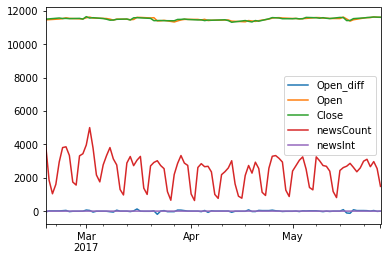

In [217]:
df = df[['Open', 'Close', 'newsCount', 'newsInt']].diff().dropna().join(df, lsuffix = '_diff')
df[['Open_diff','Open', 'Close', 'newsCount', 'newsInt']].head(100).plot()
df

In [218]:
# Testing for causality of each time series' past values on the other (Ref https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)
maxlag=1
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  
### result: p_value for open_x and newsCount_y is 0.0000 (<0.05) so definite causation relationship (open predicts news)
### Also, p_value for newsCount_x and open_y is 0.3957 (>00.05) so news count does not predict y
#This makes this system of multi time series a bad candidate for using VAR models

,Open_diff_x,Close_diff_x,newsCount_diff_x,newsInt_diff_x,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,newsCount_x,norm_x,newsInt_x
Open_diff_y,1.0000,0.0000,0.6970,0.6944,0.5190,0.7165,0.0693,0.0059,0.0059,0.0000,0.6846,0.6526,0.1490
Close_diff_y,0.0002,1.0000,0.0085,0.0610,0.8845,0.7223,0.6321,0.8636,0.8636,0.0000,0.0309,0.3151,0.1442
newsCount_diff_y,0.4702,0.0327,1.0000,0.0000,0.7903,0.8703,0.8736,0.9807,0.9807,0.0323,0.0000,0.0000,0.0000
newsInt_diff_y,0.0320,0.0064,0.0000,1.0000,0.7728,0.8457,0.8029,0.9970,0.9970,0.2029,0.0000,0.0000,0.0000
Open_y,0.0000,0.0000,0.5695,0.4736,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7862,0.6301,0.1159
High_y,0.0000,0.0000,0.2770,0.8845,0.0126,1.0000,0.0000,0.0000,0.0000,0.0000,0.2447,0.3999,0.0729
Low_y,0.0000,0.0000,0.5307,0.6312,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.1048,0.3113,0.0263
Close_y,0.0007,0.2762,0.0077,0.0610,0.2933,0.3672,0.0000,1.0000,1.0000,0.0000,0.0342,0.3619,0.1643
Adj Close_y,0.0007,0.2762,0.0077,0.0610,0.2933,0.3672,0.0000,1.0000,1.0000,0.0000,0.0342,0.3619,0.1643
Volume_y,0.0000,0.0006,0.0000,0.9160,0.6312,0.7095,0.2416,0.3615,0.3615,1.0000,0.2678,0.0489,0.0877


For newsCount_diff and Close_diff


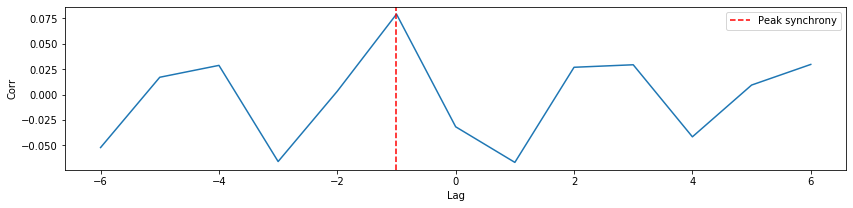

In [220]:
stock_label = 'Close_diff'
news_label = 'newsCount_diff'

#### TIME LAGGED CORRELATION ref [https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9]
def crosscorr(datax, datay, lag=0, wrap=False, toprint=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0 lag in datay compared to datax
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        shiftedy = datay.shift(lag)  
        corr = datax.corr(shiftedy)
        if toprint:
            plt.subplots(figsize=(10,2))
            plt.plot(datax.head(45).index, datax.head(45), label=datax.name)
            plt.xticks(rotation=90)
            plt.legend()
            plt.subplots(figsize=(10,2))
            plt.plot(shiftedy.head(45).index, shiftedy.head(45), label=datay.name)
            plt.xticks(rotation=90)
            plt.legend()
            plt.show()
            print(f"Corr = {corr} for lag {lag}")
        return corr

def max_synchrony(d1, d2, lag_range):
    rs = [crosscorr(d1,d2, lag, toprint=False) for lag in range(-int(lag_range),int(lag_range+1))]
    offset = np.ceil(len(rs)/2)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(np.arange(-int(lag_range),int(lag_range+1)), rs)
    ax.axvline(np.argmax(rs)-lag_range,color='r',linestyle='--',label='Peak synchrony')
    ax.set_xlabel("Lag")
    ax.set_ylabel("Corr")
    plt.legend()

max_synchrony(df[news_label], df[stock_label], 6)
print(f"For {news_label} and {stock_label}")

In [ ]:

# remove spurious correlations?
df = df.asfreq('D')
res_news = sm.tsa.seasonal_decompose(df['newsCount_diff'])
resplot = res_news.plot()
res_news = sm.tsa.seasonal_decompose(df['Close_diff'])
resplot = res_news.plot()

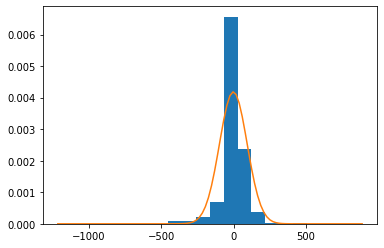

-1.8824074786856126 95.3527371661097


In [221]:
stock_label = 'Close_diff'
news_label = 'newsCount_diff'

plt.hist(df[stock_label].to_numpy(), bins = 20, density=True) 
mean,std = norm.fit(df[stock_label].to_numpy())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()
print(mean, std)

In [224]:
stock_label = 'Open_diff'
news_label = 'newsCount'

def pearson_pvalues(x):
    if len(x) < 2:
        return np.nan
    return pearsonr(x[stock_label], x[news_label])[1]

def subsample(diff, label):
    '''
    randomly and uniformly subsample
    '''
    neg_len = len(diff[diff[label]<=0].dropna())
    pos_len = len(diff[diff[label]>0].dropna())
    pos_idx = diff[diff[label]>0].dropna().index
    neg_idx = diff[diff[label]<=0].dropna().index
    if neg_len<pos_len:
        pos_idx = pd.Index(np.random.choice(pos_idx, neg_len, replace=False))
    else:
        if pos_len<neg_len:
            neg_idx = pd.Index(np.random.choice(neg_idx, pos_len, replace=False))
    return diff.loc[pos_idx.union(neg_idx)]

num_std = 3
stock_diff = df[[stock_label]]
mean,std = norm.fit(stock_diff.to_numpy())

st = stock_diff[(stock_diff<= mean+(num_std*std)) & (stock_diff >= mean-(num_std*std))].dropna()
st = subsample(st, label=stock_label)
joint_diff = st.join(df[[news_label]])
ranges = [math.floor(joint_diff[stock_label].min()), 0, math.ceil(joint_diff[stock_label].max())+1]
groups = joint_diff.groupby(pd.cut(joint_diff[stock_label], ranges))[[stock_label, news_label]]
corrs = groups.corr().dropna()
pvals = groups.apply(pearson_pvalues).dropna() # p-values
avgNewsCount = groups.agg({news_label: "sum"}).dropna()
count = groups.count()
corrs, pvals, avgNewsCount, count

(                     Open_diff  newsCount
 Open_diff                                
 (-256, 0] Open_diff   1.000000  -0.226154
           newsCount  -0.226154   1.000000
 (0, 239]  Open_diff   1.000000   0.196741
           newsCount   0.196741   1.000000, Open_diff
 (-256, 0]    4.449714e-07
 (0, 239]     1.198452e-05
 dtype: float64,               newsCount           
               Open_diff  newsCount
 Open_diff                         
 (-256, 0] -20629.752925  1018223.0
 (0, 239]   18330.902592  1035336.0,            Open_diff  newsCount
 Open_diff                      
 (-256, 0]        488        488
 (0, 239]         488        488)